# <i class="fa-solid fa-repeat"></i> Recap: Regression Models

In [1]:
from IPython.display import HTML
import plotly.io as pio

# Helper function to return a Plotly figure as self-contained HTML.
def show_plotly(fig, include_js='cdn'):
    return HTML(pio.to_html(fig, full_html=False, include_plotlyjs=include_js))

One of the the most important concepts in any multivariate statistics seminar such as [psy111](https://mibur1.github.io/psy111) are (linear) regression models. Let's quickly recap this concept and how to implement it in Python.

Have a look at the following code, which creates some simulated data. Can you deduce from the code, what the underlying pattern is?

```{code-block} ipython3
import numpy as np
import pandas as pd

x = np.linspace(-5, 5, 30)
y = (x**3 + np.random.normal(0, 15, size=x.shape)) / 50

df = pd.DataFrame({'x': x, 'y': y})
```
<details>
<summary><strong>Click to reveal the plot</strong></summary>

Here you can see the data in a scatterplot, with a linear regression model fitted to the data. Do you think the linear model fits the data well?

In [2]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore", message=".*Polyfit may be poorly conditioned.*")

# Generate sample data
np.random.seed(42)
x = np.linspace(-5, 5, 30)
y = (x**3 + np.random.normal(0, 15, size=x.shape)) / 50
df = pd.DataFrame({'x': x, 'y': y})

# Create scatter trace for the raw data
scatter = go.Scatter(
    x=df['x'],
    y=df['y'],
    mode='markers',
    marker=dict(
        size=10,
        color='lightgrey',
        line=dict(color='gray', width=2)
    ),
    name='Data'
)

# Fit a linear regression model (polynomial order 1)
coeffs = np.polyfit(df['x'], df['y'], 1)
x_fit = np.linspace(-5, 5, 400)
y_fit = np.polyval(coeffs, x_fit)

# Create regression trace with a thicker blue line
regression = go.Scatter(
    x=x_fit,
    y=y_fit,
    mode='lines',
    name='Model',
    line=dict(width=3, color='#4c72b0')
)

# Combine the traces into one figure
data = [scatter, regression]

# Define layout without annotations or sliders
layout = go.Layout(
    xaxis=dict(title="x", range=[-5.5, 5.5], tickfont=dict(size=14), fixedrange=True, gridwidth=1, zerolinewidth=1),
    yaxis=dict(title="y", range=[-3, 3], tickfont=dict(size=14), fixedrange=True, gridwidth=1, zerolinewidth=1),
    legend=dict(font=dict(size=14)),
    margin=dict(l=10, r=10, t=30, b=20),
)
fig = go.Figure(data=[scatter, regression], layout=layout)
show_plotly(fig, include_js='cdn')

</details>
<br>

Let's take a closer look at the model. As introduced last semester, we can e.g. use the `statsmodels.formula.api` library to specify and fit regression models with a formula notation similar to R. We use the `ols()` class to fit the model specified as `y ~ x` which translates to "y predicted by x":

In [3]:
import statsmodels.formula.api as smf

model = smf.ols("y ~ x", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     85.59
Date:                Mon, 27 Oct 2025   Prob (F-statistic):           5.21e-10
Time:                        13:06:35   Log-Likelihood:                -21.439
No. Observations:                  30   AIC:                             46.88
Df Residuals:                      28   BIC:                             49.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0564      0.093     -0.604      0.5

In this output, the most important information are the model parameters displayed under `coef` and the performance statistics such as the `R-squared`.
You can see that our model has an R-squared of 0.753, which means that the model explains 75% of the variance in the data. That's pretty good! But I'm sure we can do better. After all, life is more complicated than just a straigth line, no? <sub>(And we also know that the underlying data was simulated according to a 3rd order polynomial.)</sub>

In [4]:
# Scatter trace for the raw data with updated marker properties
scatter = go.Scatter(x=df['x'], y=df['y'], mode='markers',
                     marker=dict(size=10, color='lightgrey', line=dict(color='gray', width=2)), name='Data') 

# Generate regression curves for polynomial orders 1 through 30 with updated line properties
regression_traces = []
r2_list = []
x_fit = np.linspace(-5, 5, 400)
for order in range(1, 31):
    coeffs = np.polyfit(df['x'], df['y'], order)
    y_fit = np.polyval(coeffs, x_fit)
    trace = go.Scatter(x=x_fit, y=y_fit, mode='lines', name='Model', visible=False,
                       line=dict(width=3, color='#4c72b0'))
    regression_traces.append(trace)

    y_pred = np.polyval(coeffs, df['x'])
    r2 = 1 - np.sum((df['y'] - y_pred) ** 2) / np.sum((df['y'] - df['y'].mean()) ** 2)
    r2_list.append(r2)

# Combine data: always show the scatter trace, and one regression trace at a time (set first one visible)
data = [scatter] + regression_traces
data[1]['visible'] = True

# Create slider steps
steps = []
for i in range(30):
    vis = [True] + [False] * 30
    vis[i + 1] = True
    step = dict(
        method="update",
        args=[{"visible": vis},
              {"annotations": [dict(x=0.02, y=0.98, xref="paper", yref="paper", text=f"Model R² = {r2_list[i]:.3f}", 
                                    showarrow=False, font=dict(size=18, color="gray"), align="left")]}],
        label=str(i + 1)
    )
    steps.append(step)

# Define the slider
sliders = [dict(active=0, currentvalue={"prefix": "Order of the polynomial regression model: "}, pad={"t": 30}, steps=steps)]

# Define the layout with
layout = go.Layout(
    annotations=[dict(x=0.02, y=0.98, xref="paper", yref="paper", text=f"Model R² = {r2_list[0]:.3f}",
                      showarrow=False, font=dict(size=18, color="gray"), align="left")],
    sliders=sliders,
    xaxis=dict(title="x", range=[-5.5, 5.5], tickfont=dict(size=14), fixedrange=True, gridwidth=1, zerolinewidth=1),
    yaxis=dict(title="y", range=[-3, 3], tickfont=dict(size=14), fixedrange=True, gridwidth=1, zerolinewidth=1),
    legend=dict(font=dict(size=14)),
    margin=dict(l=10, r=10, t=30, b=20),
)

# Create the figure
fig = go.Figure(data=[scatter] + regression_traces, layout=layout)
show_plotly(fig, include_js='cdn')

As you probably expected, the R² increases as you increase the order of the polynomial in the regression model. However, this doesn't stop after the 3rd order polynomial (which is the true function that generated the data). The R² continues to increase until it hits 1 for a model that includes a 29th-order polynomial. You can see that the model now goes through every single one of the data points. This did not happen by chance! A polynomial of degree 29 can perfectly interpolate the present data, which consists of 30 data points. This is because a polynomial of degree n−1 has n coefficients, which can be uniquely determined to pass through n distinct points (given that all the x-values are distinct).

```{margin}
{{training_data}}\. Training data refers to the data which was used for model fitting.
```

```{margin}
{{testing_data}}\. Testing data refers to data which was used to evaluate the performance of a model. This is new, unseen data, meaning that it was not used for training.
```

But what should you do with this information? Well, as the topic of this seminar is *statistical and machine learning*, we are usually concerned with making predictions for new, unseen data. Until now, we have always fit (trained) and evaluated (tested) our model on the same data, aiming to make statistical inferences about the coefficients of relatively small models. We can call this the *training data*<sup>{{training_data}}</sup>. However, we can also generate new data with the same underlying function and test the model on this repeatedly generated data that reflects the same underlying true association between y and x. We call this the *testing data*<sup>{{testing_data}}</sup>:

In [5]:
# Compute polynomial coefficients fitted on the existing data
training_coeffs = []
for order in range(1, 31):
    coeffs = np.polyfit(df['x'], df['y'], order)
    training_coeffs.append(coeffs)

# Generate new test data (randomly draw 30 data points to not have all points equally spaced)
np.random.seed(69)
x_all_test = np.linspace(-5, 5, 100)
indices_test = np.sort(np.random.choice(np.arange(100), size=30, replace=False))
x_test = x_all_test[indices_test]
y_test = (x_test**3 + np.random.normal(0, 15, size=x_test.shape)) / 50
df_test = pd.DataFrame({'x': x_test, 'y': y_test})

# Create a scatter trace for test data
test_scatter = go.Scatter(
    x=df_test['x'],
    y=df_test['y'],
    mode='markers',
    marker=dict(size=10, color='lightgrey', line=dict(color='gray', width=2)),
    name='Test Data'
)

# Compute Test Predictions and R² for Each Polynomial Order
regression_traces_test = []
r2_test_list = []
x_fit = np.linspace(-5, 5, 400)
for order in range(1, 31):
    coeffs = training_coeffs[order-1]
    
    # Generate the regression curve
    y_fit = np.polyval(coeffs, x_fit)
    trace = go.Scatter(
        x=x_fit,
        y=y_fit,
        mode='lines',
        name='Model',
        visible=False,
        line=dict(width=3, color='#4c72b0')
    )
    regression_traces_test.append(trace)
    
    # Compute test predictions for the test data
    y_pred_test = np.polyval(coeffs, df_test['x'])
    r2_test = 1 - np.sum((df_test['y'] - y_pred_test)**2) / np.sum((df_test['y'] - df_test['y'].mean())**2)
    r2_test_list.append(r2_test)

# Build Interactive Figure for Test Data
data_test = [test_scatter] + regression_traces_test
data_test[1]['visible'] = True

# Build slider steps: each step makes one regression curve visible and updates the annotation with the test R².
steps_test = []
for i in range(30):
    vis = [True] + [False] * 30
    vis[i + 1] = True
    step = dict(
        method="update",
        args=[{"visible": vis},
              {"annotations": [dict(x=0.02, y=0.98, xref="paper", yref="paper", 
                                    text=f"Test R² = {r2_test_list[i]:.3f}",
                                    showarrow=False, font=dict(size=18, color="gray"), align="left")]}],
        label=str(i + 1)
    )
    steps_test.append(step)

sliders_test = [dict(
    active=0,
    currentvalue={"prefix": "Order of polynomial: "},
    pad={"t": 30},
    steps=steps_test
)]

layout_test = go.Layout(
    annotations=[dict(x=0.02, y=0.98, xref="paper", yref="paper",
                      text=f"Test R² = {r2_test_list[0]:.3f}",
                      showarrow=False, font=dict(size=18, color="gray"), align="left")],
    sliders=sliders_test,
    xaxis=dict(title="x", range=[-5.5, 5.5], tickfont=dict(size=14), fixedrange=True, gridwidth=1, zerolinewidth=1),
    yaxis=dict(title="y", range=[-3, 3], tickfont=dict(size=14), fixedrange=True, gridwidth=1, zerolinewidth=1),
    legend=dict(font=dict(size=14)),
    margin=dict(l=10, r=10, t=30, b=20),
)

fig_test = go.Figure(data=[test_scatter] + regression_traces_test, layout=layout_test)
show_plotly(fig_test, include_js='cdn')

```{margin}
{{overfit}}\. Overfitting refers to fitting patterns in the training data which do not generalize to the testing data.
```

<a href="https://commons.wikimedia.org/wiki/File:William_of_Ockham.png" target="_blank">
  <figure style="float:right; width:17%; margin-bottom:0.5em; margin-left:1.5em;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/7/70/William_of_Ockham.png" alt="William Occam" style="width:100%;">
    <figcaption style="margin-top:0.2em; font-size:small;">William of Occam <sup>4</sup></figcaption>
  </figure>
</a>
<br>

You can see that the R² now has a peak around a 3rd order polynomial regression model and then drastically decreases for higher order polynomials. This means that our previously trained models do not really fit our new data anymore. Why is this the case? Basically, these higher-order models became too flexible and *overfit* <sup>{{overfit}}</sup> to the training data. Once we apply the models to new testing data, they will produce a much worse performance, as they are too specialized (they basically just memorized the training data).

```{margin}
{{occam}}\. Image by <a href="https://commons.wikimedia.org/wiki/File:William_of_Ockham.png">Moscarlop</a>, used under <a href="https://creativecommons.org/licenses/by-sa/3.0/">CC BY-SA 3.0</a>.
```

So how can we then find the best model that avoids overfitting? From your classes in basic (psychological) methods, you might be familiar with *Occam's razor*, which states that:

> Entia non sunt multiplicanda praeter necessitatem.

This essentially translates to *"Before you try a complicated hypothesis, you should make quite sure that no simplification of it will explain the facts equally well"*. Our model should thus be as simple as possible, but as complex as necessary. In machine learning, this concept is often referred to as the [](2_bias_variance), which we will explore next week.

## Different Ways of Implementing Regression Models

There are many different Python packages that allow you to implement regression models, with popular choices being `statsmodels`, `numpy`, and `sklearn`. The specific choice ultimately depends on your preferences and goals.

At the top of this section, you have already seen the high-level *formula API* solution from `statsmodels`. For a cubic model, this would look like this:

In [6]:
import statsmodels.formula.api as smf

# Fit model
model = smf.ols("y ~ x + I(x**2) + I(x**3)", data=df).fit()

# Predictions
x_test = pd.DataFrame({"x": [-4, 1, 3]})
print(model.predict(x_test))

0   -1.149150
1   -0.148156
2    0.380523
dtype: float64


Alternatively, you can use the lower-level `OLS()` approach, which requires you to manually specify the design matrix (make sure to add a column for the intercept/bias):

In [7]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

# Create design matrix
X = x.reshape(-1, 1)
poly = PolynomialFeatures(degree=3, include_bias=True)
X_poly = poly.fit_transform(X)

# Fit model
model = sm.OLS(y, X_poly).fit()

A cool thing about statsmodels is that you can get the model results in various forms:

In [8]:
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     143.0
Date:                Mon, 27 Oct 2025   Prob (F-statistic):           2.83e-16
Time:                        13:06:35   Log-Likelihood:                0.48444
No. Observations:                  30   AIC:                             7.031
Df Residuals:                      26   BIC:                             12.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1381      0.070     -1.969      0.0

In [9]:
print(summary.tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1381      0.070     -1.969      0.060      -0.282       0.006
x1            -0.0398      0.039     -1.014      0.320      -0.121       0.041
x2             0.0092      0.006      1.561      0.131      -0.003       0.021
x3             0.0206      0.002      9.148      0.000       0.016       0.025


In [10]:
print(model.params) # [beta0, beta1, beta2, beta3]

[-0.13806828 -0.03982915  0.00916298  0.02057822]


In [11]:
# Prediciton
x_test = np.array([[-4], [1], [3]])
X_test_poly = poly.transform(x_test)
y_hat = model.predict(X_test_poly)
print(y_hat)

[-1.14914986 -0.14815624  0.38052287]


With the polynomial features, we can also directly use `sklearn`:

In [12]:
from sklearn.linear_model import LinearRegression

# Fit model
model = LinearRegression(fit_intercept=False).fit(X_poly, y) # we already have the itercept in X_poly
print(model.coef_) # [beta0, beta1, beta2, beta3]

# Predict
y_hat = model.predict(X_test_poly)
print(y_hat)

[-0.13806828 -0.03982915  0.00916298  0.02057822]
[-1.14914986 -0.14815624  0.38052287]


And last but not least, one could also use `numpy`:

[ 0.02057822  0.00916298 -0.03982915 -0.13806828]
[-1.14914986 -0.14815624  0.38052287]


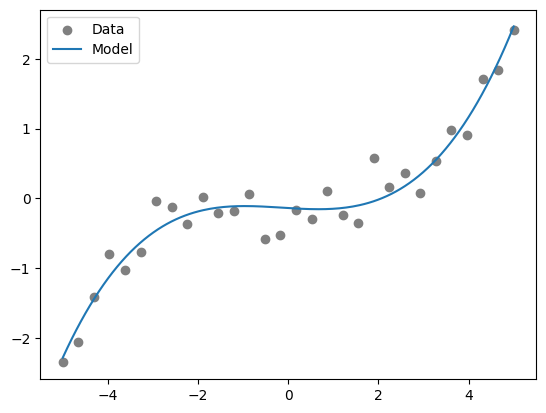

In [13]:
import numpy as np
from matplotlib import pyplot as plt

coeffs = np.polyfit(x, y, deg=3)
print(coeffs)
p = np.poly1d(coeffs)

# Predict
x_test = np.array([-4, 1, 3])
y_hat = p(x_test)
print(y_hat)

# Plot
fig, ax = plt.subplots()
ax.scatter(x, y, color="gray", label="Data")
x_fit = np.linspace(x.min(), x.max(), 200)
ax.plot(x_fit, p(x_fit), label="Model")
plt.legend();

In practice, `statsmodels` is ideal for statistical analysis and reporting (provides a lot of information for inference), `scikit-learn` for machine learning pipelines and prediction, and `numpy` for quick or lightweight fits.

```{admonition} Summary
:class: tip

- Regression models can be used as prediction models in the context of machine learning.
- The performance of a prediction model should always be assessed on new, unseen data.
- It is often useful to look for the simplest possible model that still provides sufficiently accurate answers.
- There are many Python packages that allow you to implement regression models. Chose whichever suits your goals best.
```